# Visualização e análise de dados de turismo de Maceió

Os dados utilizados nas análises e visualizações a seguir foram retirados do observatório de turismo de maceió

http://observatorioturismo.maceio.al.gov.br/indicadores-aeroporto/

## AEROPORTO
Através de dados disponibilizados pela INFRAERO e ANAC, acompanhamos a movimentação de passageiros no Aeroporto de Maceió, assim como as origens e disponibilidade de assentos por aeronave.
Os dados abordados nos gráficos a seguir é uma análise do histórico da movimentação mensal e anual de passageiros (soma de embarques e desembarques) a partir de 2011 até os dias atuais.

Dados atualizados no terceiro trimestre de 2018

## Forecasting & Séries temporais

Forecasting é uma técnica que busca aprender padrões em dados do passado com o objetivo de prever essa informação no futuro. 
Essa abordagem é útil em diferentes cenários, tais como: prever fluxo de venda, valor de ativos, consumo elétrico e etc.

No exemplo a seguir, iremos observar como a movimentação de passageiros varia com o passar do tempo. Para isso temos uma sequência de datas e o valor da movimentação nessas respectivas datas. Essa estrutura
também pode ser chamada série temporal. Através da série temporal será possível entender o comportamento e prever qual seria a movimentação dos passageiros em datas futuras. A possibilidade de prever tal movimentação permite
que as decisões sejam tomadas de forma estratégica aproveitando momentos de fluxo de menor para realizar promoções e de maior fluxo pra explorar serviços relacionados.

## Prophet
O Prophet é uma solução open-source desenvolvida pelo facebook para realizar previsões em séries temporais de forma simples. O modelo que o Prophet utiliza para realizar as previsões utiliza três componentes.

y(t) = g(t) + s(t) + h(t) + e<sub>t</sub>

onde:
- **g** é a função de tendência, que modela mudanças não periódicas nas séries temporais

- **s** é a função de sazonalidade, que modela mudanças periódicas nas séries

- **h** representa os efeitos dos feriados nas séries

- **e<sub>t</sub>** representa o erro

Vale a pena ressaltar que é possível estender o modelo e adicionar novos componentes. Para entender melhor sobre os componentes recomendo que leiam o artigo original. A referência está no final deste artigo.

### Pré-requisitos

#### Requisitos do sistema
É recomendado utilizar uma máquina com no mínimo 2GB de memória livre.

#### Bibliotecas
- numpy
- cython
- pandas
- pystan
- fbprophet
- matplotlib

In [1]:
# Comando para instalar os requisitos
# !pip install numpy
# !pip install pandas
# !pip install cython
# !pip install matplotlib
# !pip install pystan --no-cache-dir --no-binary :all:
# !pip install fbprophet --no-cache-dir --no-binary :all:

In [2]:
%config IPCompleter.greedy=True
import pandas as pd

# flattening list    
flatten = lambda l: [item for sublist in l for item in sublist]

# importando dataset
df = pd.read_csv("data-v1/indicadores-aeroporto.csv")
df


,MÊS,2011,2012,2013,2014,2015,2016,2017,2018
0,01 - JAN,175313,176159,212203,205811,239821,242014,236749,245492.0
1,02 - FEV,130890,128567,154771,150950,157081,173710,154240,172312.0
2,03 - MAR,135269,130979,161828,158027,156544,156982,166921,177458.0
3,04 - ABR,125055,129328,145903,147258,144026,147405,144097,153230.0
4,05 - MAI,117815,123772,143091,134585,140995,138375,141656,152955.0
5,06 - JUN,104523,130138,142561,118926,139526,131534,140023,156220.0
6,07 - JUL,135718,148590,171888,156752,178671,189513,198606,207606.0
7,08 - AGO,114306,132855,154392,144471,153361,157391,165129,176194.0
8,09 - SET,120575,139172,152156,146426,148887,146330,165616,166680.0
9,10 - OUT,128153,148178,165995,170082,165707,161899,174424,NaN


## Pré-Processamento
Como vimos na célula anterior, cada linha representa um mês e as colunas são os anos.

Para realizarmos a análise dos dados utilizando o Prophet é necessário mudar a estrutura do dataset, pois o Prophet espera um dataset contendo apenas duas colunas **ds** e **y**.
A primeira contém as datas dos registros, na segunda serão armazenados os registros que serão preditos de fato.

In [3]:
# Formatação e limpeza dos dados

# Criando matriz tansposta
df_transposed = df.transpose()

# Criando nova coluna apenas com os dígitos do mês [01 - 12]
df_transposed.loc['MES_DIGIT'] = [ x[0:2] for x in df_transposed.loc['MÊS']]

# Para cada coluna é gerada uma lista de 12 meses no formato yyyy-mm
dates = [year +"-"+ df_transposed.loc['MES_DIGIT'] for year in df.columns[1:].values]

# Todas as listas são mescladas criando uma lista única de datas
dates = flatten(dates)

# Cria uma lista única com todos os passajeiros
passengers = df_transposed.drop(['MÊS','MES_DIGIT']).values.flatten()

# Criando dataframe na estrutura esperada pelo prophet (DS, Y)
ts_df = pd.DataFrame({'ds': dates, 'y': passengers})

# Cria índice
ts_df['ds'] = pd.DatetimeIndex(ts_df['ds'])

# Exibe 5 primeiros registros do dataset
ts_df.head()

,ds,y
0,2011-01-01,175313
1,2011-02-01,130890
2,2011-03-01,135269
3,2011-04-01,125055
4,2011-05-01,117815


## Visualização
Após a estruturação dos dados é importante visualizá-los, para isso usaremos a biblioteca matplotlib

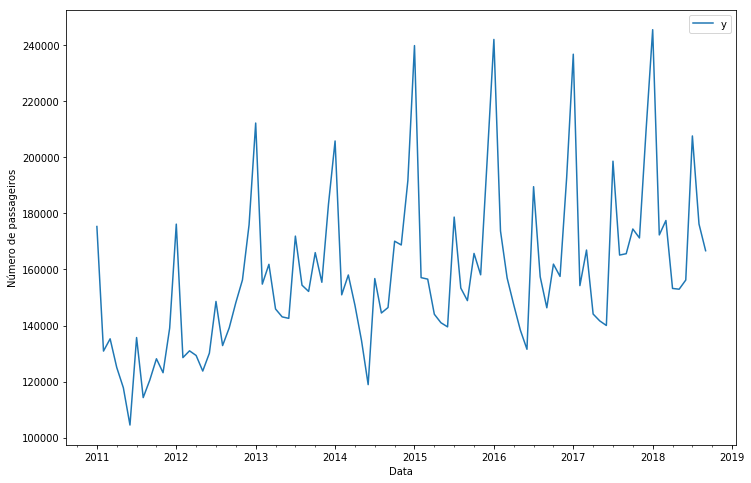

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

ax = ts_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Número de passageiros')
ax.set_xlabel('Data')

plt.show()

## Treinamento
Neste momento iremos treinar o Prophet deixando uma margem de erro de 5%

In [5]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95)
model.fit(ts_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Predição
Como estamos trabalhando com intervalos mensais isso quer dizer que cada período considerado pelo Prophet equivale a 1 mês.

In [10]:
# Gerando datas futuras para predição
future = model.make_future_dataframe(periods=13, freq = 'm')
future.tail(15)

,ds
94,2018-11-01
95,2018-12-01
96,2018-12-31
97,2019-01-31
98,2019-02-28
99,2019-03-31
100,2019-04-30
101,2019-05-31
102,2019-06-30
103,2019-07-31


In [14]:
# Aplicando algoritmo de predição
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
94,2018-11-01,176786.143341,161537.369510,192031.514710
95,2018-12-01,204938.015225,189593.580649,222367.743743
96,2018-12-31,235303.957154,219196.015252,251948.967186
97,2019-01-31,181709.140340,165423.493272,198297.896503
98,2019-02-28,185867.064392,170699.485708,201495.366907
99,2019-03-31,166293.094483,149649.578853,182578.063256
100,2019-04-30,163673.918714,146813.375251,180632.644127
101,2019-05-31,151814.097783,135936.978203,168126.730275
102,2019-06-30,191687.036421,174700.329928,208161.991800
103,2019-07-31,172905.868200,158557.730687,190023.501621


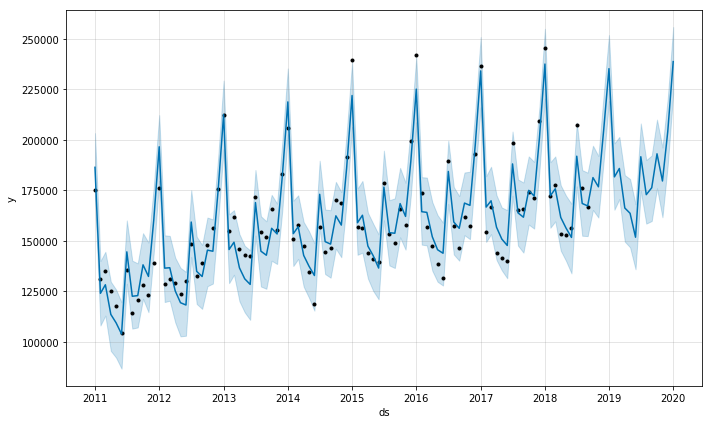

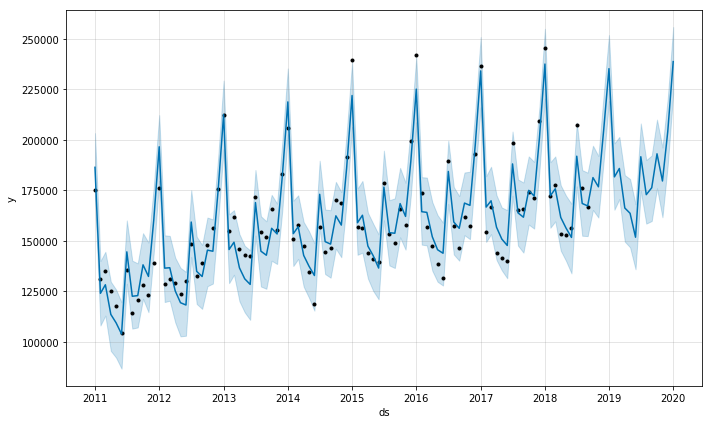

In [16]:
# Exibindo valores para novas datas 

model.plot(forecast,uncertainty=True)

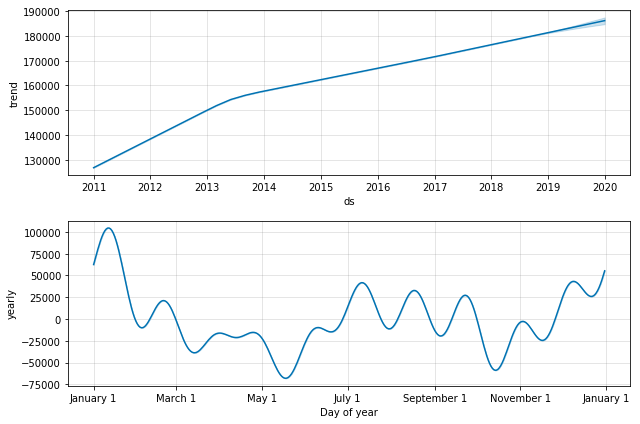

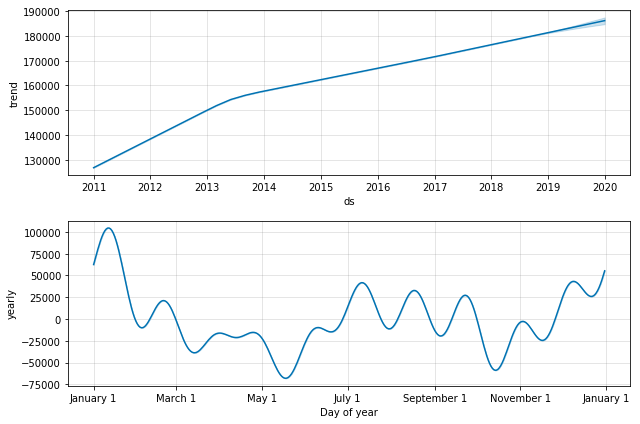

In [13]:
# Exibindo tendência e comportanto anual
model.plot_components(forecast)

## Referências

- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
- https://github.com/urgedata/pythondata/blob/master/fbprophet/fbprophet_part_one.ipynb
- https://facebook.github.io/prophet/docs/quick_start.html#python-api
- https://peerj.com/preprints/3190/